# MRI-Enhance: Enhancing MRI Scans through Advanced Low-Light Image Processing with Convolutional Neural Networks [![GitHub](https://img.shields.io/badge/GitHub-Repository-<COLOR>.svg)](https://github.com/MechaBA/MRI-Enhance)

<hr />


This demo is created by Berkay Arslan for CAP5610 - Spring 2024
- Improved Image Clarity: Enhance the visibility and clarity of low-light MRI scans, which could hopingly be taken further to aid medical professionals in diagnosis and analysis.
- Detail Preservation: The image enhancement aims to maintain essential details and structural information in the MRI scans while minimizing noise and improving overall image quality.
- Consistent Image Enhancement: I have tested more than 50 MRI scans and adjusted the settings to ensure reproducible enhancement results across different MRI scans, which promotes reliability in diagnostic procedures.

# If you are having trouble running steps 5 or 6, try reloading the page, or try **File** --> **Open in playground mode** and go through the demo. If still having trouble, wait some time and try steps 5 and 6 again.

# Download Medical Images (MRI Scans)
Uncomment the task you would like to perform

In [4]:
import os
import shutil

# Run to receive medical_images.zip in files, or copy and paste link to download medical_images
# !wget 'https://github.com/MechaBA/MRI-Enhance/raw/main/medical_images.zip' -O 'medical_images.zip'

In [ ]:
# Uncomment below to delete folder (medical_images.zip) in files
# !rm -rf medical_images.zip

# OR uncomment below to delete individual images (all images are med1-5) in files
# !rm -rf med2.jpg

# 1. Upload Images
Either download the sample images or upload your own images. You can find open-source MRI images to use at [**MedPix**](https://medpix.nlm.nih.gov/home)

In [5]:
import os
from PIL import Image
from google.colab import files

uploaded = files.upload()
filename = next(iter(uploaded))
input_path = os.path.join('/content/', filename)

orig = Image.open(input_path)

Saving med3.jpg to med3.jpg


# 2. Setup
- Install huggingface_hub to have a trained dataset

In [6]:
!pip install transformers huggingface_hub
!pip install tensorflow

In [7]:
from huggingface_hub import from_pretrained_keras
import transformers
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2

# 3. Load Pretrained Dataset
- Load a pretrained dataset model, which can be found at [**Hugging Face**](https://huggingface.co/keras-io/low-light-image-enhancement)


In [8]:
model = from_pretrained_keras("keras-io/low-light-image-enhancement")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/2.46k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

variables/variables.index:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

variables/variables.data-00000-of-00001:   0%|          | 0.00/325k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/153k [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

lol_dataset.zip:   0%|          | 0.00/347M [00:00<?, ?B/s]

# 4. Image Processing
- The 'post_process' function utilizes TensorFlow operations to augment image clarity while maintaining pixel intensities within their limits

In [9]:
def post_process(image, output):
    def apply_enhancement(x, channel):
        return x + channel * (tf.square(x) - x)

    x = apply_enhancement(image, output[:, :, :, :3])
    x = apply_enhancement(x, output[:, :, :, 3:6])
    x = apply_enhancement(x, output[:, :, :, 9:12])
    enhanced_img = apply_enhancement(x, output[:, :, :, 12:15])
    enhanced_img = apply_enhancement(enhanced_img, output[:, :, :, 15:18])
    enhanced_img = apply_enhancement(enhanced_img, output[:, :, :, 18:21])
    enhanced_img = apply_enhancement(enhanced_img, output[:, :, :, 21:24])
    enhanced_img = tf.clip_by_value(enhanced_img, 0.0, 1.0)

    return enhanced_img

# 5. Low-Light MRI Image Visualization
- Used to turn up the brightness of the MRI image, while keeping details in tact for accurate diagnosis
-It doesn't have the clarity you would hope for

(1, 180, 180, 3)


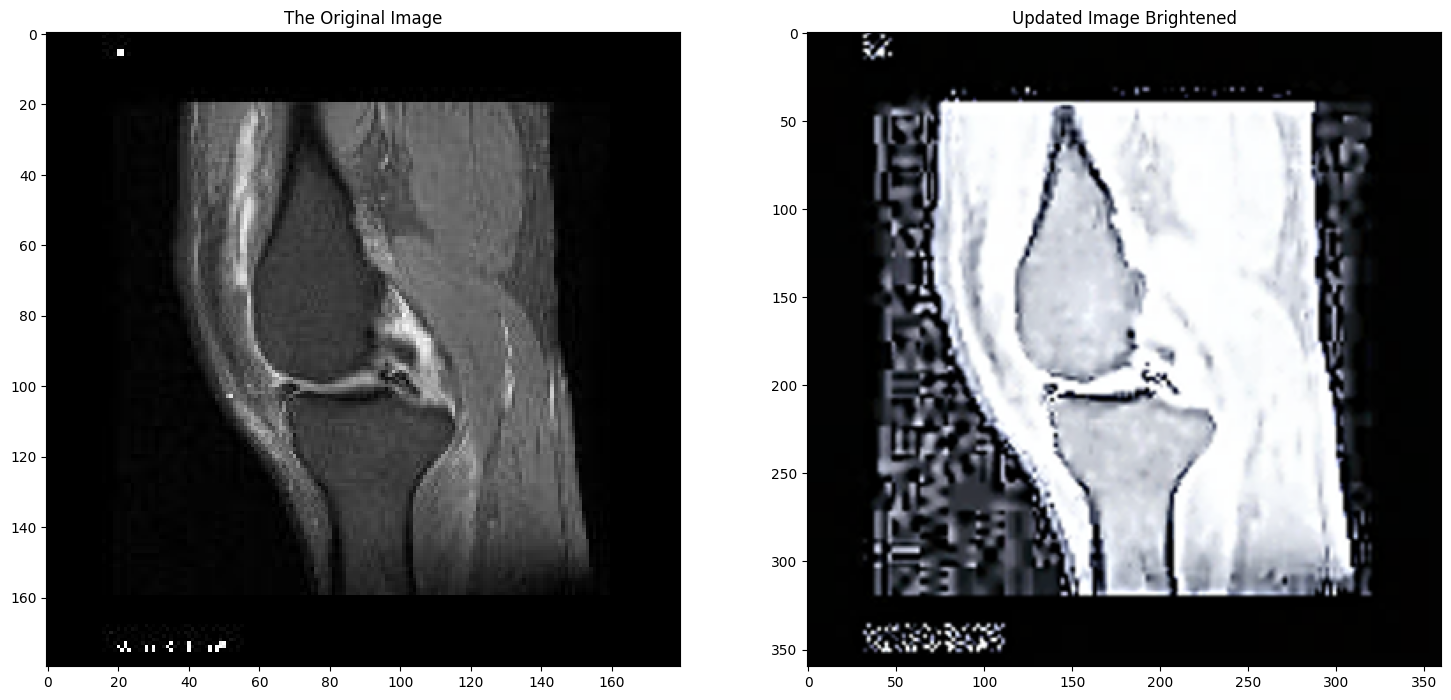

In [12]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter, ImageOps
from google.colab import files
from IPython.display import display
from skimage.restoration import denoise_wavelet
from keras.preprocessing.image import img_to_array, array_to_img
from keras.models import load_model


def inference(o_image):
  image = keras.preprocessing.image.img_to_array(o_image)
  image = image.astype("float32") / 255.0
  image = np.expand_dims(image, axis=0)
  print(image.shape)
  output_image = model(image)
  output_image = post_process(image, output_image)
  output_image = tf.cast((output_image[0, :, :, :] * 255), dtype = np.uint8)
  output_image = Image.fromarray(output_image.numpy())
  return output_image

def adjust_contrast_sharpness(image, contrast_factor = 1.1, sharpness_factor = 1.3):
    if image.mode != 'RGB':
        image = image.convert('RGB')
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(contrast_factor)
    enhancer = ImageEnhance.Sharpness(image)
    return enhancer.enhance(sharpness_factor)

def adjust_gamma(image, gamma=0.9):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return Image.fromarray(cv2.LUT(np.array(image, dtype = np.uint8), table))

def denoise_image(image, d = 5, sigmaColor = 75, sigmaSpace = 75):
    np_image = np.array(image)
    denoised_image = cv2.bilateralFilter(np_image, d, sigmaColor, sigmaSpace)
    return Image.fromarray(denoised_image)

def adjust_saturation(image, saturation_factor = 1.2):
    enhancer = ImageEnhance.Color(image)
    return enhancer.enhance(saturation_factor)

def apply_clahe(image, clip_limit = 2.0, tile_grid_size=(8, 8)):
    np_image = np.array(image)
    lab = cv2.cvtColor(np_image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    np_image_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return Image.fromarray(np_image_clahe)

def balance_contrast_brightness(image):
    np_image = np.array(image)
    np_image = cv2.normalize(np_image, None, alpha = 0, beta = 255, norm_type=cv2.NORM_MINMAX)
    return Image.fromarray(np_image)

def unsharp_mask(image, radius = 2, percent = 150, threshold = 3):
    if image.mode != 'RGB':
        image = image.convert('RGB')
    return image.filter(ImageFilter.UnsharpMask(radius=radius, percent=percent, threshold=threshold))

def wavelet_denoising(image):
    image_np = np.array(image)
    image_denoised = denoise_wavelet(image_np, channel_axis = -1, convert2ycbcr = True, method = 'BayesShrink', mode = 'soft')
    image_denoised = (image_denoised * 255).astype(np.uint8)
    return Image.fromarray(image_denoised)

def upscale_image(image, scale_factor=2):
    open_cv_image = np.array(image)
    open_cv_image = open_cv_image[:, :, ::-1].copy()
    width = int(open_cv_image.shape[1] * scale_factor)
    height = int(open_cv_image.shape[0] * scale_factor)
    dim = (width, height)
    upscaled_image = cv2.resize(open_cv_image, dim, interpolation=cv2.INTER_CUBIC)
    return Image.fromarray(upscaled_image[:, :, ::-1])


enhanced = inference(orig)
enhanced = adjust_contrast_sharpness(enhanced)
enhanced = adjust_gamma(enhanced, gamma = 0.9)
enhanced = denoise_image(enhanced, d = 5, sigmaColor = 60, sigmaSpace = 60)
enhanced = adjust_saturation(enhanced, saturation_factor = 1.3)
enhanced = apply_clahe(enhanced)
enhanced = balance_contrast_brightness(enhanced)
enhanced = unsharp_mask(enhanced)
enhanced = wavelet_denoising(enhanced)
enhanced = upscale_image(enhanced)


# Figure Size
plt.figure(figsize = (18, 9))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(orig)
plt.title('The Original Image')
plt.axis('on')

# Updated Image
plt.subplot(1, 2, 2)
plt.imshow(enhanced)
plt.title('Updated Image Brightened')
plt.axis('on')

plt.show()

# 6. Convolutional Neural Network MRI Image Enhancement Visualization
- Before and after images showing the enhancement of the CNN model on MRI scans

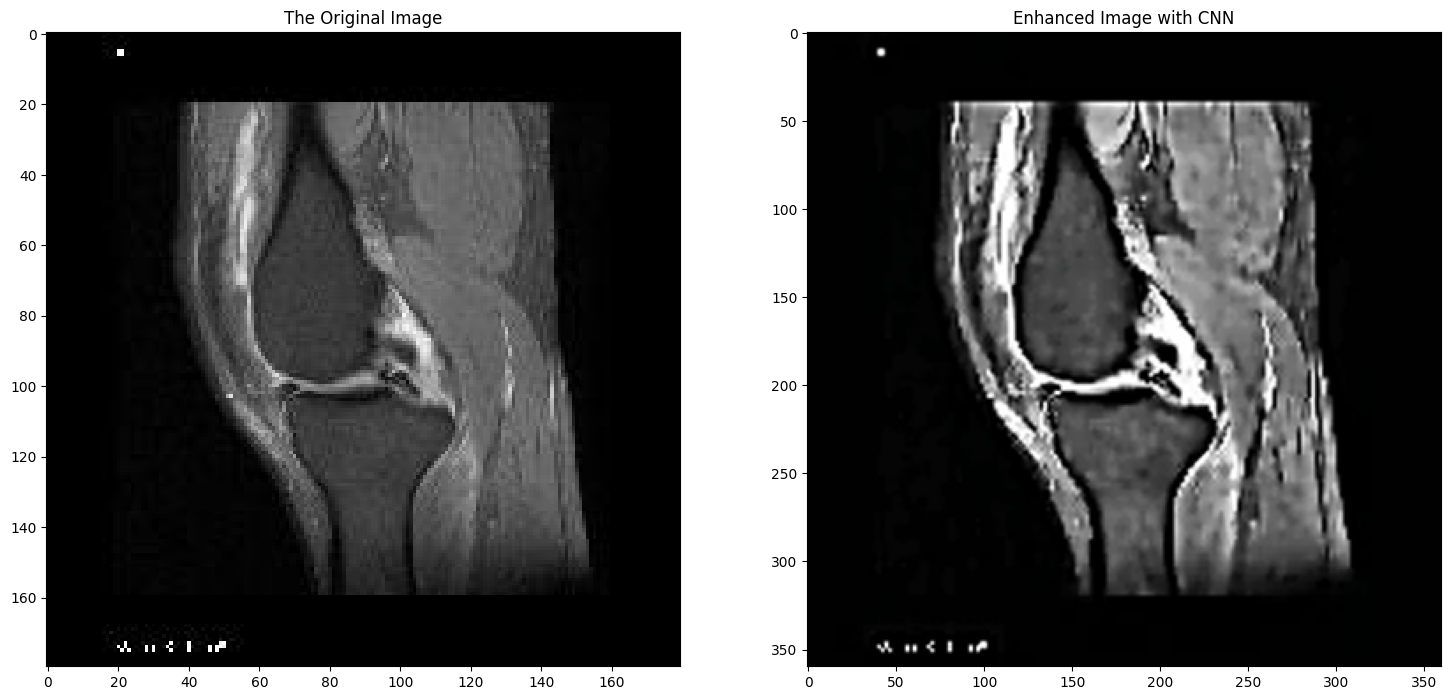

In [13]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter, ImageOps
from google.colab import files
from IPython.display import display
from skimage.restoration import denoise_wavelet
from keras.models import load_model
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import (Input, DepthwiseConv2D, BatchNormalization, ReLU, Conv2D, LeakyReLU, Add, Conv2DTranspose, Concatenate, MaxPooling2D, Dropout, UpSampling2D)


def build_cnn(input_shape):
    inputs = Input(shape=input_shape)

    x = DepthwiseConv2D((3, 3), padding = 'same', depth_multiplier = 1)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(64, (1, 1), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Convolutional block
    x = Conv2D(64, (3, 3), padding = 'same', dilation_rate = 2)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.1)(x)

    # Residual block
    for _ in range(2):
        identity = x
        x = Conv2D(64, (3, 3), padding = 'same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha = 0.1)(x)
        x = Conv2D(64, (3, 3), padding = 'same')(x)
        x = BatchNormalization()(x)
        x = Add()([x, identity])
        x = ReLU()(x)

    # Convolutional block with dropout
    x = Conv2D(128, (3, 3), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = Dropout(0.5)(x)

    # Convolutional block with transpose convolution
    x = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Concatenate()([x, identity])

    # Convolutional block
    x = Conv2D(128, (3, 3), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # This is a pooling layer
    x = MaxPooling2D((2, 2))(x)

    # Residual block
    for _ in range(2):
        identity = x
        x = Conv2D(128, (3, 3), padding = 'same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(128, (3, 3), padding = 'same')(x)
        x = BatchNormalization()(x)
        x = Add()([x, identity])
        x = ReLU()(x)

    # Convolutional layer with the use of sigmoid
    x = Conv2D(64, (3, 3), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    outputs = Conv2D(3, (3, 3), padding = 'same', activation = 'sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model



def build_srgan(input_shape):
    vgg19 = VGG19(include_top = False, weights = 'imagenet', input_shape = input_shape)
    vgg19.layers.pop()
    vgg19 = Model(inputs = vgg19.inputs, outputs = vgg19.layers[-1].output)

    for layer in vgg19.layers:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    features = vgg19(inputs)

    # Increasing the image resolution
    x = UpSampling2D(size=(2,2))(features)
    x = Conv2D(256, (3, 3), padding = 'same')(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2,2))(x)
    x = Conv2D(128, (3, 3), padding = 'same')(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2,2))(x)
    x = Conv2D(64, (3, 3), padding = 'same')(x)
    x = ReLU()(x)

    # Output convolution
    outputs = Conv2D(3, (9, 9), padding = 'same', activation = 'tanh')(x)

    # Creating the model
    model = Model(inputs = inputs, outputs = outputs)
    return model

# Building the model
srgan_model = build_srgan(input_shape = (None, None, 3))



def inference(image, model):
    image_np = img_to_array(image) / 255.0
    image_np = np.expand_dims(image_np, axis = 0)
    enhanced_np = model.predict(image_np)[0]
    enhanced_np = (enhanced_np * 255).astype(np.uint8)
    return Image.fromarray(enhanced_np)

def adjust_contrast_sharpness(image, contrast_factor = 1.1, sharpness_factor = 1.3):
    if image.mode != 'RGB':
        image = image.convert('RGB')
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(contrast_factor)
    enhancer = ImageEnhance.Sharpness(image)
    return enhancer.enhance(sharpness_factor)

def adjust_gamma(image, gamma = 0.9):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return Image.fromarray(cv2.LUT(np.array(image, dtype = np.uint8), table))

def denoise_image(image, d = 5, sigmaColor = 75, sigmaSpace = 75):
    np_image = np.array(image)
    denoised_image = cv2.bilateralFilter(np_image, d, sigmaColor, sigmaSpace)
    return Image.fromarray(denoised_image)

def adjust_saturation(image, saturation_factor = 1.2):
    enhancer = ImageEnhance.Color(image)
    return enhancer.enhance(saturation_factor)

def apply_clahe(image, clip_limit = 2.0, tile_grid_size = (8, 8)):
    np_image = np.array(image)
    lab = cv2.cvtColor(np_image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit = clip_limit, tileGridSize = tile_grid_size)
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    np_image_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return Image.fromarray(np_image_clahe)

def balance_contrast_brightness(image):
    np_image = np.array(image)
    np_image = cv2.normalize(np_image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX)
    return Image.fromarray(np_image)

def unsharp_mask(image, radius = 2, percent = 150, threshold = 3):
    if image.mode != 'RGB':
        image = image.convert('RGB')
    return image.filter(ImageFilter.UnsharpMask(radius = radius, percent = percent, threshold = threshold))

def wavelet_denoising(image):
    image_np = np.array(image)
    image_denoised = denoise_wavelet(image_np, channel_axis = -1, convert2ycbcr = True, method = 'BayesShrink', mode = 'soft')
    image_denoised = (image_denoised * 255).astype(np.uint8)
    return Image.fromarray(image_denoised)

def upscale_image(image, scale_factor = 2):
    open_cv_image = np.array(image)
    open_cv_image = open_cv_image[:, :, ::-1].copy()
    width = int(open_cv_image.shape[1] * scale_factor)
    height = int(open_cv_image.shape[0] * scale_factor)
    dim = (width, height)
    upscaled_image = cv2.resize(open_cv_image, dim, interpolation=cv2.INTER_CUBIC)
    return Image.fromarray(upscaled_image[:, :, ::-1])


enhanced = orig.copy()
enhanced = adjust_contrast_sharpness(enhanced)
enhanced = adjust_gamma(enhanced, gamma = 0.9)
enhanced = denoise_image(enhanced, d = 5, sigmaColor = 60, sigmaSpace = 60)
enhanced = adjust_saturation(enhanced, saturation_factor = 1.3)
enhanced = apply_clahe(enhanced)
enhanced = balance_contrast_brightness(enhanced)
enhanced = unsharp_mask(enhanced)
enhanced = wavelet_denoising(enhanced)
enhanced = upscale_image(enhanced)


# Figure Size
plt.figure(figsize = (18, 9))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(orig)
plt.title('The Original Image')
plt.axis('on')

# Enhanced Image
plt.subplot(1, 2, 2)
plt.imshow(enhanced)
plt.title('Enhanced Image with CNN')
plt.axis('on')

plt.show()

# **Thanks** for participating in my demo, if you have any questions, please feel free to ask.
# - Berkay Arslan